# Getting Started

### Recommend using a virtual environment (conda is common for ML)

Create conda env with:

    conda create -n YourNameHere python=3.11

To activate conda env:

    conda activate YourNameHere


### Install required packages

    conda install numpy pandas scikit-learn matplotlib pillow -c conda-forge

    conda install pytorch torchvision torchaudio -c pytorch

    pip install iterative-stratification timm


### Relevant Resources

Demo .csv Dataset:

https://www.dropbox.com/scl/fi/1tck9b8bab8z3n38m7jio/miml_dataset.zip?rlkey=11nwt23wa40o8iqmp24898d3g&e=5&dl=0 


## 1. Imports & Hyperparameters

In [ ]:
import random
import numpy as np
import torch
import pandas as pd
import os
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import matplotlib.pyplot as plt

USE_GPU = True

# --- Partitioning Proportions --- (Ensure total == 1.0)
TRAIN_RATIO = 0.8                   
VAL_RATIO = 0.1                    
TEST_RATIO = 0.1       

# --- Seeds for Reproducibility ---
RANDOM_SEED = 42
random.seed(RANDOM_SEED) # Python built‑in
np.random.seed(RANDOM_SEED) # NumPy
torch.manual_seed(RANDOM_SEED) # PyTorch (CPU)

# --- GPU Device Setup -----------------------------------------
if USE_GPU:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

if (USE_GPU and device.type == "cuda"):
    torch.cuda.manual_seed(RANDOM_SEED) # Seeding for PyTorch (all GPUs)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

print(f"Using device: {device}")


## 2. Load Labels from .csv/.json to DataFrame for Easy Handling


### a. For JSON

In [ ]:
NDJSON_PATH = 'demo_360.ndjson'
IMG_DIR = "miml_dataset/images"  

max_count = 0
deepest_order = None
with open(NDJSON_PATH, "r") as file:
    for line in file:
        record = json.loads(line)
        found_columns = []
        for project in record.get("projects", {}).values():
            for label in project.get("labels", []):
                for cls in label.get("annotations", {}).get("classifications", []):
                    found_columns.append(cls["name"])
        if len(found_columns) > max_count:
            max_count = len(found_columns)
            deepest_order = found_columns
print("Deepest order of classifications/labels:", deepest_order)

In [ ]:
# Stream the NDJSON and build one dict per image
records = []
distance_columns = set()
with open(NDJSON_PATH, "r") as file:
    for line in file:
        record = json.loads(line)
        ext_id = record["data_row"]["external_id"]
        # initialize the row with external_id + all label cols set to NaN
        row = {"external_id": ext_id} 
        for label in deepest_order:
            row[label] = np.nan
        # fill in each classification
        for project in record.get("projects", {}).values():
            for label in project.get("labels", []):
                for cls in label["annotations"].get("classifications", []):
                    name = cls.get("name")
                    if name not in deepest_order:
                        continue
                    # Case: Free‑text fields (Extra Notes)
                    if cls.get("text_answer"):
                        row[name] = cls["text_answer"].get("content")
                    # Case: Checklist fields (confidence score and distance)
                    elif cls.get("checklist_answers"):
                        answers = [a.get("name") for a in cls["checklist_answers"]]
                        # extract the numeric (confidence) answer
                        conf = next((a for a in answers if a and a[0].isdigit()), None)
                        # extract the non‑numeric (distance) answer
                        dist = next((a for a in answers if not (a and a[0].isdigit())), None)

                        row[name] = conf
                        # create the distance column on the fly
                        distance_col = str(name)+"_distance"
                        distance_columns.add(distance_col)
                        row[distance_col] = dist
                    # Case: Radio fields (Lily, Problematic, Revisit)
                    elif cls.get("radio_answer"):
                        row[name] = cls["radio_answer"].get("name")
                    # Fallback: raw value string
                    else:
                        row[name] = cls.get("value")
        records.append(row)
df_all = pd.DataFrame(records) # Build the DataFrame (pandas will union in any distance cols)
nonlabel_columns = {"external_id", "Problematic", "Extra Notes", "Revisit"}
nonlabel_columns.update(distance_columns)
label_columns = [col for col in df_all.columns if col not in nonlabel_columns]
df_all.head()

In [ ]:
# Re‑order columns by adding labels w/ its corresponding *_distance column(if it exists) in the order as it appears in LabelBox(deepest_order)
ordered_columns = ["external_id"]
for label in deepest_order:
    ordered_columns.append(label)
    distance_col = str(label)+"_distance"
    if distance_col in df_all.columns: # Also add corresponding *_distance column if it exists
        ordered_columns.append(distance_col)
df_all = df_all[ordered_columns]
df_all.head()

# ordered = (
#     ["external_id"] +
#     label_columns +
#     distance_cols 
# )
# df_all = df_all[ordered]
# df_all.head()

In [ ]:
def create_img_path_mapping(root_img_dir):
    """
    Recursively scans the root image directory for JPEG images in any "split_jpg" folder
    and creates a mapping from each image's basename to its full local file path.
    
    Returns:
        dict: Mapping { img_filename : img_path }.
    """
    glob_pattern = os.path.join(root_img_dir, "*", "*", "split_jpg", "*.jpg")
    img_paths = glob.glob(glob_pattern, recursive=True)
    mapping = {}
    for img_path in img_paths:
        img_filename = os.path.basename(img_path)
        mapping[img_filename] = img_path
    return mapping

def get_base_filename(filename):
    '''
    Strip off suffixes like "_left.jpg", "_right.jpg" or just drop the extension
    '''
    for suffix in ["_left.jpg", "_right.jpg"]:
        if filename.endswith(suffix):
            return filename[:-len(suffix)] # Remove specified suffix
    return os.path.splitext(filename)[0] # Fallback: Removes extensions

path_map = create_img_path_mapping(IMG_DIR) # Build the mapping from filename to full path  
group_id_series= df_all["external_id"].apply(get_base_filename) # Create group_id column
img_path_series = df_all["external_id"].map(path_map) # Create image_path column
df_all.insert(0, "group_id", group_id_series) # Add group_id and image_path
df_all.insert(1, "image_path", img_path_series) # Add image_path
df_all = df_all.drop(columns=nonlabel_columns) # Drop 
df_all.head()

In [ ]:
df_binary = df_all.copy().fillna(0) # Make a binary copy with NaN turned to 0s
df_binary.head()

In [ ]:
POSITIVE_THRESHOLD = 3

def to_binary(entry): 
    num = int(str(entry).split()[0])  # parse out a leading integer
    return int((num > 0) and int(num <= POSITIVE_THRESHOLD))

for col in label_columns:
    df_binary[col] = df_binary[col].apply(to_binary)
df_binary.head()

### b. For .csv

In [44]:
# ===============================================================
# Helper Function: Load .csv to Datafame
# ===============================================================
def load_csv_to_df(csv_filepath, images_dir):
    """
    Reads a CSV file into a dataframe and adds 'group_id' and 'image_path' columns.

    Returns:
        pd.DataFrame: A standardized DataFrame with columns:
                      'Filenames', 'group_id', 'image_path', plus any additional label columns.
    """
    df_csv = pd.read_csv(csv_filepath) 
    df_csv["group_id"] = [os.path.splitext(filename)[0] for filename in df_csv["Filenames"]] # Add 'group_id' by removing the file extension.
    df_csv["image_path"] = [os.path.join(images_dir, filename) for filename in df_csv["Filenames"]] # Add 'image_path' by joining the images_dir with the filename.
    return df_csv     

In [ ]:
# Load .csv to a DataFrame
CSV_FILE_PATH = 'miml_dataset/miml_labels_1.csv'  
IMG_DIR = 'miml_dataset/images'     

df = load_csv_to_df(CSV_FILE_PATH, IMG_DIR)

pd.set_option('display.expand_frame_repr', False)
print(df.head())

  Filenames  desert  mountains  sea  sunset  trees group_id                 image_path
0     1.jpg       1          0    0       0      0        1  miml_dataset/images/1.jpg
1     2.jpg       1          0    0       0      0        2  miml_dataset/images/2.jpg
2     3.jpg       1          0    0       0      0        3  miml_dataset/images/3.jpg
3     4.jpg       1          1    0       0      0        4  miml_dataset/images/4.jpg
4     5.jpg       1          0    0       0      0        5  miml_dataset/images/5.jpg


## 3. Identify Label Columns + Fill in empty non-responses

In [ ]:
nonlabel_cols = {"external_id", "Filenames", "group_id", "image_path", "Problematic", "Extra Notes", "Revisit"}
label_columns = [col for col in df.columns if col not in nonlabel_cols and not col.endswith("_distance")]
df[label_columns] = df[label_columns].fillna(0) # Fill NaN entries with 0

print(f"Label Columns: {label_columns}\n")
print(df.head())

Label Columns: ['desert', 'mountains', 'sea', 'sunset', 'trees']

  Filenames  desert  mountains  sea  sunset  trees group_id                 image_path
0     1.jpg       1          0    0       0      0        1  miml_dataset/images/1.jpg
1     2.jpg       1          0    0       0      0        2  miml_dataset/images/2.jpg
2     3.jpg       1          0    0       0      0        3  miml_dataset/images/3.jpg
3     4.jpg       1          1    0       0      0        4  miml_dataset/images/4.jpg
4     5.jpg       1          0    0       0      0        5  miml_dataset/images/5.jpg


## 4. Partition Data and Labels into Train/Validation/Test Sets

In [ ]:
# ===============================================================
# Helper Function: Stratified Split
# ===============================================================
def group_stratified_split(df, label_columns, group_col, split_ratio, seed):
    """
    Splits the DataFrame into two subsets in a group-aware manner.
    For each unique group (defined by group_col), this function 
    aggregates the label vectors, and then performs a stratified split 
    based on these aggregated multilabel targets.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        label_columns (list): List of columns representing multilabel targets.
        group_col (str): Column name used to group the data (ie "group_id").
        split_ratio (float): Proportion of groups to use in the "second" split.
        seed (int): Random seed for reproducibility.
        
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Two DataFrame splits (first split and second split).
    """
    unique_groups_array = df[group_col].unique()
    aggregated_labels_list = [] 
    for group in unique_groups_array:
        group_df = df[df[group_col] == group] # Extract the subset of rows for this group.
        series_max = group_df[label_columns].max() # Use max() across rows for each label column to simulate a logical OR combining the labels per group to a panda Series
        agg_labels = series_max.values # convert to numpy 1D array
        aggregated_labels_list.append(agg_labels)
    aggregated_labels_array = np.vstack(aggregated_labels_list) # stack into shape (n_groups, n_labels)
    # Initialize the multilabel stratified shuffle split with the desired test size and random seed.
    splitter = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=split_ratio, random_state=seed)
    # Use the splitter to get indices for train and test groups based on the aggregated labels.
    for first_split_idx, second_split_idx in splitter.split(unique_groups_array.reshape(-1, 1), aggregated_labels_array):
        first_groups = unique_groups_array[first_split_idx]
        second_groups = unique_groups_array[second_split_idx]
    # Create the final DataFrame splits by selecting rows that belong to each group split.
    df_split_1 = df[df[group_col].isin(first_groups)].reset_index(drop=True)
    df_split_2 = df[df[group_col].isin(second_groups)].reset_index(drop=True)
    return df_split_1, df_split_2

In [48]:
# First, split off the test set.
df_train_and_val, df_test = group_stratified_split(df, label_columns, "group_id", TEST_RATIO, RANDOM_SEED)
# Next, split train/validation.
relative_val_ratio = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
df_train, df_val = group_stratified_split(df_train_and_val, label_columns, "group_id", relative_val_ratio, RANDOM_SEED)

print("Number of Groups per Partition:")
print("Train groups:", len(df_train))
print("Validation groups:", len(df_val))
print("Test groups:", len(df_test))

Number of Groups per Partition:
Train groups: 1597
Validation groups: 205
Test groups: 198


In [ ]:
# Save DataFrame splits to .csv
df_train.to_csv("train_partition.csv", index=False)
df_val.to_csv("val_partition.csv", index=False)
df_test.to_csv("test_partition.csv", index=False)
print("Partitions saved to .csv files.")

# Load DataFrames from .csv
df_train = pd.read_csv('train_partition.csv')
df_val = pd.read_csv('val_partition.csv')
df_test = pd.read_csv('test_partition.csv')
print("Partition files loaded.")

Partitions saved to .csv files.
Partition files loaded.


## 5. Verify Even Stratify Splitting


Label distribution in Original Dataset:
  desert: 20.45% positive
  mountains: 22.90% positive
  sea: 29.00% positive
  sunset: 23.25% positive
  trees: 28.00% positive


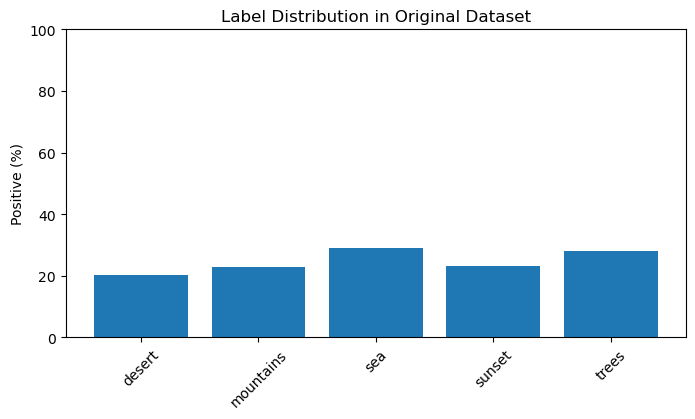


Label distribution in Train:
  desert: 20.48% positive
  mountains: 22.92% positive
  sea: 29.05% positive
  sunset: 23.29% positive
  trees: 28.05% positive


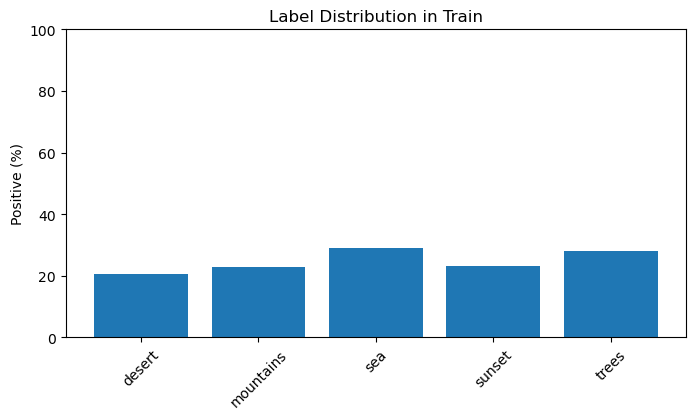


Label distribution in Validation:
  desert: 20.00% positive
  mountains: 22.44% positive
  sea: 28.29% positive
  sunset: 22.93% positive
  trees: 27.32% positive


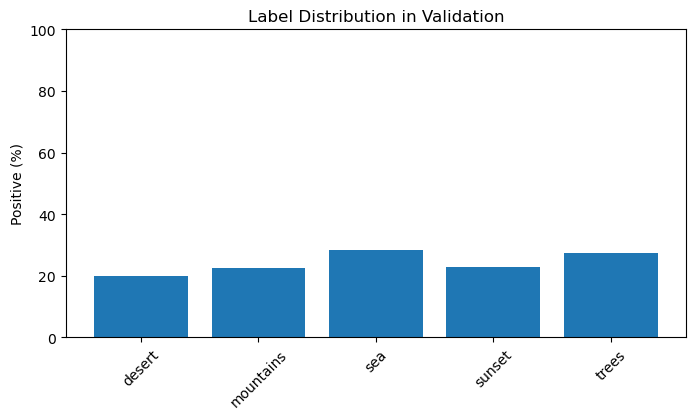


Label distribution in Test:
  desert: 20.71% positive
  mountains: 23.23% positive
  sea: 29.29% positive
  sunset: 23.23% positive
  trees: 28.28% positive


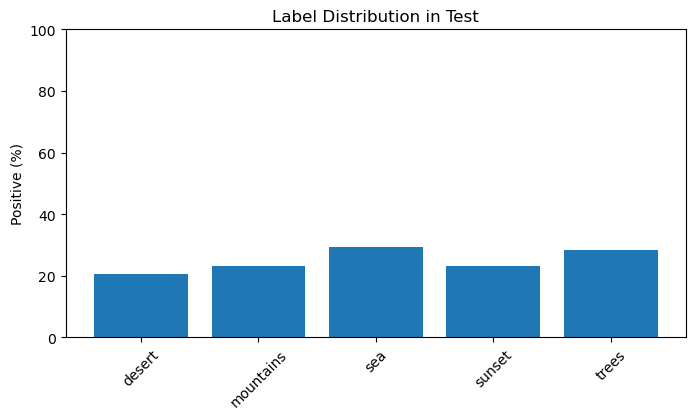

In [50]:
def show_label_distribution(df, label_columns, partition_name="Dataset"):
    """
    Prints and plots the positive percentage for each label.
    """
    print(f"\nLabel distribution in {partition_name}:")
    positive_rates = {}
    for label in label_columns:
        pos_rate = df[label].mean() * 100
        positive_rates[label] = pos_rate
        print(f"  {label}: {pos_rate:.2f}% positive")
    plt.figure(figsize=(8,4))
    plt.bar(positive_rates.keys(), positive_rates.values())
    plt.ylabel("Positive (%)")
    plt.title(f"Label Distribution in {partition_name}")
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.show()
    
# Visualize the label distribution across the entire dataset.
show_label_distribution(df, label_columns, partition_name="Original Dataset")
# Check Label Ratios Across Train/Valid/Test 
show_label_distribution(df_train, label_columns, partition_name="Train")
show_label_distribution(df_val, label_columns, partition_name="Validation")
show_label_distribution(df_test, label_columns, partition_name="Test")